# Tinygrad MNIST

## Imports

In [ ]:
##UNCOMMENT IN GOOGLE COLAB
##!pip install tinygrad 

import math
import matplotlib.pyplot as plt
import hashlib
import requests
import gzip
import os
from tinygrad.nn import optim
from tinygrad.helpers import getenv
from tinygrad.tensor import Tensor
from torchvision.utils import make_grid, save_image
import torch
from tqdm import trange
import numpy as np
from pathlib import Path


%matplotlib inline


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Fetch Dataset

In [ ]:

def fetch(url):

    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()


X_train = fetch(
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28)).astype(np.float32)
Y_train = fetch(
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch(
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28)).astype(np.float32)
Y_test = fetch(
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]


## Create Model

In [ ]:
def batch(BS):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    x = X_train[samp].reshape((-1, 28*28))
    y_list = Y_train[samp]
    y_ = np.zeros((len(y_list), 10), np.float32)
    y_[range(y_.shape[0]), y_list] = 1
    return Tensor(x), Tensor(y_)


def eval():
    Y_test_preds_out = model.forward(
        Tensor(X_test.reshape((-1, 28*28)))).numpy()
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()


def layer_init(m, h):
    return Tensor.uniform(m, h)*math.sqrt(6/(2*m*h))


def gaussian_init(m, h):
    ret = np.random.uniform(-1., 1., size=(m, h))/np.sqrt(m*h)
    return Tensor(ret.astype(np.float32))


class NeuralNet:
    def __init__(self, layers=[784, 128, 10]):
        self.layers = layers
        self.params = [[], []]
        for k in range(len(layers)-1):
            self.params[1].append(gaussian_init(layers[k], layers[k+1]))
            self.params[0].append(gaussian_init(1, layers[k+1]))

    def forward(self, x):
        for k in range(len(self.params)):
            x = x.dot(self.params[1][k])+self.params[0][k]
            if k != len(self.params)-1:
                x = x.relu()
        return x.sigmoid()


## Train Model

In [ ]:
model = NeuralNet()

In [ ]:

LR = 0.01
opt = optim.SGD([*model.params[0], *model.params[1]], lr=LR)

BS = 128
# ... complete data loader here
for k in range(2):

    for l in range(1000):

        x, y = batch(BS)

        out = model.forward(x)
        # print(out.mean(axis=1).numpy())
        # print(out.numpy().mean(axis=0).shape)

        loss = (out-y).pow(2).mean(axis=0).mean()

        if not (l % 100):
            print(f"accuracy on test data is {eval()}")
        opt.zero_grad()
        loss.backward()
        opt.step()
    LR *= 0.1
    opt = optim.SGD([*model.params[0], *model.params[1]], lr=LR)


accuracy on test data is 0.149
accuracy on test data is 0.8061
accuracy on test data is 0.9055
accuracy on test data is 0.9203
accuracy on test data is 0.9252
accuracy on test data is 0.9285
accuracy on test data is 0.9369
accuracy on test data is 0.9388
accuracy on test data is 0.943
accuracy on test data is 0.9422
accuracy on test data is 0.9481
accuracy on test data is 0.9485
accuracy on test data is 0.9487
accuracy on test data is 0.9498
accuracy on test data is 0.9505
accuracy on test data is 0.9498
accuracy on test data is 0.9503
accuracy on test data is 0.95
accuracy on test data is 0.9501
accuracy on test data is 0.9509


## Evaluation

In [ ]:
eval()


0.9509

## Demonstration

Predicted value is : 8, this is correct!


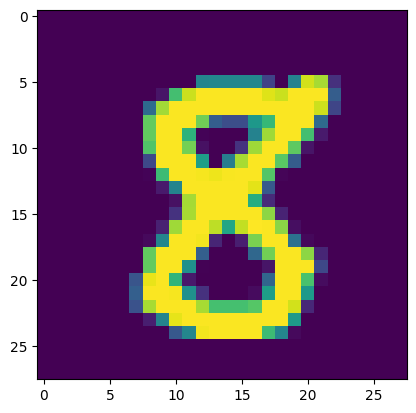

In [ ]:
samp = np.random.randint(0, X_test.shape[0], size=(1))
img = X_test[samp]
y = np.argmax(model.forward(Tensor(img.reshape((-1, 28*28)))).numpy())
print(
    f'Predicted value is : {y}, this is {["wrong.","correct!"][int(Y_test[samp][0]==y)]}')
plt.imshow(img[0], interpolation='nearest')
plt.show()
